In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

tfd = tfp.distributions
tfpl = tfp.layers

TFP docs are [here](https://www.tensorflow.org/probability/api_docs/python/tfp)

# Hands-on Bayesian neural networks with TF and TFP

From medical research to small-data scenarios, whenever we want to understand how sure the model is about its own predictions, modeling uncertainty can be immensely helpful. During the workshop we’ll learn how to build Bayesian neural networks using Tensorflow and Tensorflow Probability to model uncertainty. At the end of the workshop, you’ll have practical knowledge how to create basic types of Bayesian neural network using Tensorflow ecosystem and you'll be able to apply these techniques to your own projects. 

To fully benefit from the workshop you need: 
- good practical knowledge of Python
- practical understanding of deep learning principles 
- experience using Tensorflow (recommended) or other contemporary deep learning framework 
- good understanding of basic probability and basic distributions 
- familiarity with Bayes' theorem

## 1. TFP Components: `tfp.distributions`

In [3]:
# Let's start with Normal(0, 1)
normal = tfd.Normal(loc=0, scale=1)

### 1.1 Methods -  `.sample()`

In [4]:
# Sample from `normal`
normal.sample(10)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-2.4499056 ,  1.1270154 ,  1.0368937 , -1.5166223 , -0.88885045,
        0.6693692 , -0.33452895,  0.78436816, -0.473676  , -2.1914465 ],
      dtype=float32)>

In [5]:
# Sample form `normal` and cast the result to a numpy array
normal.sample(10).numpy()

array([-0.8952173 , -0.85343164,  0.13279957, -0.7853412 , -2.3835783 ,
        0.48664516,  0.13544907, -1.5168107 ,  0.18519977, -0.49345183],
      dtype=float32)

### * Exercise 1.1 - sample and plot

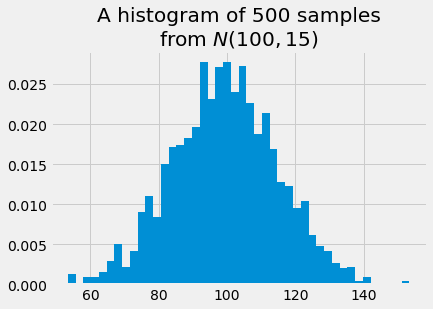

In [6]:
# Initialize a normal distribution with mean 100 and sd 15
normal = tfd.Normal(loc=100, scale=15)

# Draw 2000 samples form `normal`
samples = normal.sample(2000)

# Plot a histogram of `samples`
plt.figure(figsize=(6, 4))
plt.hist(samples.numpy(), density=True, bins=np.sqrt(2000).astype(int))
plt.title('A histogram of 500 samples\nfrom $N(100, 15)$')
plt.show()

### 1.2 Methods -  `.prob()` & `.log_prob()`

In [7]:
# Let's compare PDF values of a couple of values given `normal`
values = [70., 85., 100., 115., 130.]

for v in values:
    print(f'PDF of {v:05.1f} == {normal.prob(v):.4f}')

PDF of 070.0 == 0.0036
PDF of 085.0 == 0.0161
PDF of 100.0 == 0.0266
PDF of 115.0 == 0.0161
PDF of 130.0 == 0.0036


In [8]:
# Now, let's do the same for log_probs
values = [70., 85., 100., 115., 130.]

for v in values:
    print(f'Log PDF {v:05.1f} == {normal.log_prob(v):.4f}')

Log PDF 070.0 == -5.6270
Log PDF 085.0 == -4.1270
Log PDF 100.0 == -3.6270
Log PDF 115.0 == -4.1270
Log PDF 130.0 == -5.6270


### * Exercise 1.2 - evaluate prob and plot

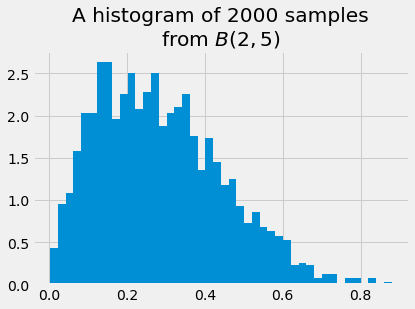

In [10]:
# Initialize a Beta distribution (`tfd.Beta`) with `concetration1=2.` and `concentration0=5.`
beta = tfd.Beta(
    concentration1=2.,
    concentration0=5.
) # YOUR CODE HERE

# Sample 2000 samples from `beta` and plot a histogram of these samples
samples = beta.sample(2000) # YOUR CODE HERE

plt.figure(figsize=(6, 4))
plt.hist(samples.numpy(), bins=np.sqrt(2000).astype(int), density=True)
plt.title('A histogram of 2000 samples\nfrom $B(2, 5)$')
plt.show()

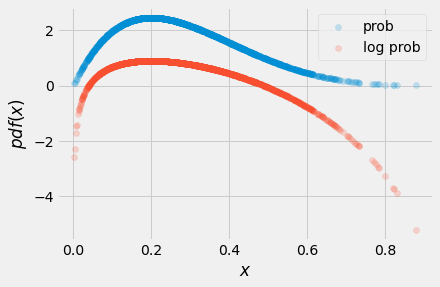

In [12]:
# Evaluate PDF and logPDF of 2000 samples drawn from `beta` usin `.prob()` and `.log_prob()` methods
beta_prob = beta.prob(samples) # YOUR CODE HERE
beta_log_prob = beta.log_prob(samples) # YOUR CODE HERE

# Plot samples vs their log_probs using a scatter plot
# On the same scatter plot, plot samples vs their respective probs
# Add labels, legend and label your axes
plt.figure(figsize=(6, 4))
plt.scatter(samples.numpy(), beta_prob.numpy(), alpha=.2, label='prob')
plt.scatter(samples.numpy(), beta_log_prob.numpy(), alpha=.2, label='log prob')
plt.xlabel('$x$')
plt.ylabel('$pdf(x)$')
plt.legend()
plt.show()

### 1.3 Shapes - batch & events

In [15]:
# Let's build a multivariate normal
normal_batch = tfd.Normal(loc=[1., 0.], scale=1.)
normal_batch

<tfp.distributions.Normal 'Normal' batch_shape=[2] event_shape=[] dtype=float32>

In [16]:
# Now, let's let's turn it into a 2d normal using `tfd.Independent`
mvn = tfd.Independent(normal_batch, reinterpreted_batch_ndims=1)
mvn

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[2] dtype=float32>

### * Exercise 1.3 - build a multivariate normal distribution

In [17]:
# Build an MVN with batch size of 2 and event shape of 3 using `tfd.Normal` and `tfd.Independent`
# Define an array of means (loc) of shape 2x3
means = np.array([
    [1., 1., 2.],
    [4., 4., 6.]
]) # YOUR CODE HERE

# Build a normal distr with batch size 2x3 use `means` as your loc, set `scale` to 1.
normal_batched = tfd.Normal(loc=means, scale=1.) # YOUR CODE HERE
normal_batched

<tfp.distributions.Normal 'Normal' batch_shape=[2, 3] event_shape=[] dtype=float64>

In [19]:
# Wrap your normal 2x3 using `tfd.Independent` 
# and reinterpret some batch dims to get the event shape of 3 while keeping batch shape of 2
mvn = tfd.Independent(normal_batched, reinterpreted_batch_ndims=1) # YOUR CODE HERE
mvn

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[2] event_shape=[3] dtype=float64>

## 2. Modleing aleatoric uncertainty - `tfp.layers`

### 2.1 `tfd.DistributionLambda` layer

#### 2.1.1 Generate data

First, let's generate some data! 

Our data generating process will be defined by the following formula:

$$\large y = 1.5x + 3 + 0.35\epsilon$$

where:

* $\epsilon \sim N(0, 1)$

In [20]:
# Generate the data
x_train = np.linspace(-1, 1, 200)[:, np.newaxis]
y_train = 1.5*x_train + 3 + 0.35*np.random.randn(200)[:, np.newaxis]

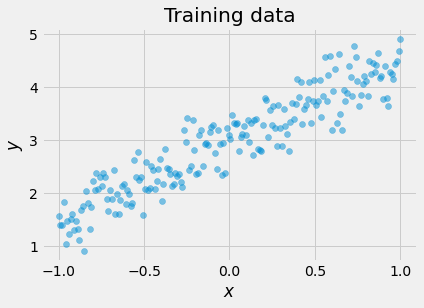

In [21]:
# Plot the data
plt.figure(figsize=(6, 4))
plt.scatter(x_train, y_train, alpha=.5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Training data')
plt.show()

#### 2.1.2 Simple model

In [22]:
# Let's build a simple linear regression model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=(1,))
])

# Compile 
model.compile(loss='mse', optimizer='sgd')

# Fit
history = model.fit(x_train, y_train, epochs=100, verbose=0)

In [23]:
# Predict
y_pred = model(x_train)

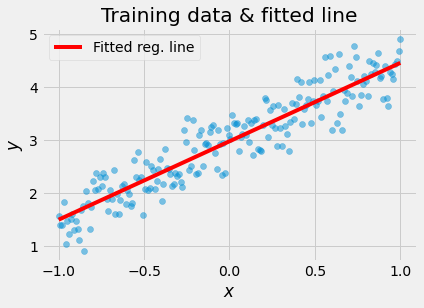

In [24]:
# Plot the data and a trained regression line
plt.figure(figsize=(6, 4))
plt.scatter(x_train, y_train, alpha=.5)
plt.plot(x_train, y_pred, label='Fitted reg. line', c='r')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Training data & fitted line')
plt.legend()
plt.show()

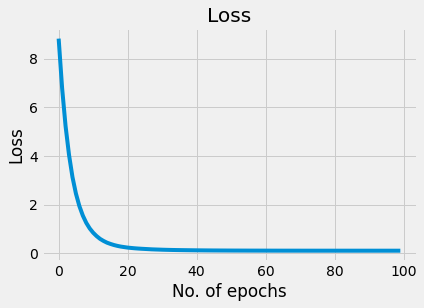

In [25]:
# Plot loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.title('Loss')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.show()

#### 2.1.3 Model with probabilistic output - aleatoric uncertainty (learn mean & std)

In [26]:
# Let's build a model with probabilistic output (mean & std)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(2, input_shape=(1,)),
    tfpl.DistributionLambda(
        lambda t: tfd.Independent(
            tfd.Normal(
                loc=t[..., :1],
                scale=tf.math.softplus(t[..., 1:])
            ),
            reinterpreted_batch_ndims=1
        )
    )
])

# Define neg. loglik. loss function
def neg_loglik(y_true, y_pred):
    return -y_pred.log_prob(y_true)

# Compile 
model.compile(loss=neg_loglik, optimizer='sgd')

# Fit
history = model.fit(x_train, y_train, epochs=300, verbose=0)

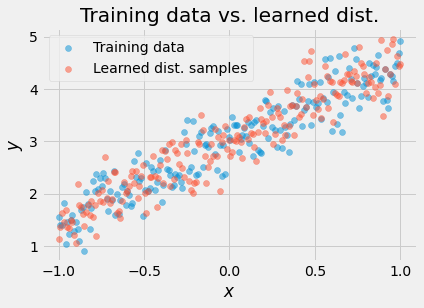

In [27]:
# Let's compare distributions - y_train & y_model
y_model = model(x_train).sample().numpy()

# Plot 
plt.figure(figsize=(6, 4))
plt.scatter(x_train, y_train, alpha=.5, label='Training data')
plt.scatter(x_train, y_model, alpha=.5, label='Learned dist. samples')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.title('Training data vs. learned dist.')
plt.show()

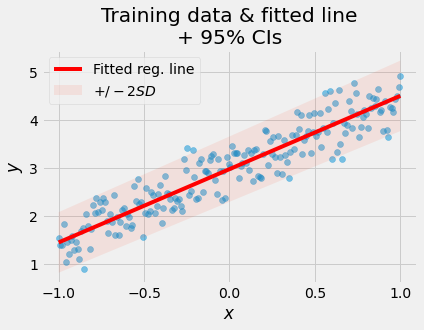

In [28]:
# Compute conf ints
y_sample = model(x_train).sample()
y_hat = model(x_train).mean()
y_sd = model(x_train).stddev()
y_hat_lower = y_hat - 2 * y_sd
y_hat_upper = y_hat + 2 * y_sd

# Plot conf ints
plt.figure(figsize=(6, 4))
plt.scatter(x_train, y_train, alpha=.5)
plt.plot(x_train, y_hat, label='Fitted reg. line', c='r')
plt.fill_between(np.squeeze(x_train), np.squeeze(y_hat_lower), np.squeeze(y_hat_upper), alpha=.1, label='$+/- 2SD$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Training data & fitted line\n+ 95% CIs')
plt.legend()
plt.show()

### 2.2 A simpler way to model aleatoric uncertainty - `tfd.layers`

In [31]:
# Let's build a model with probabilistic output (mean & std) - a simpler way
event_shape = 1

model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=tfpl.IndependentNormal.params_size(event_shape), input_shape=(1,)),
    tfpl.IndependentNormal(event_shape=event_shape)
])

# Define neg. loglik. loss function
def neg_loglik(y_true, y_pred):
    return -y_pred.log_prob(y_true)

# Compile 
model.compile(loss=neg_loglik, optimizer='sgd')

# Fit
history = model.fit(x_train, y_train, epochs=300, verbose=0)

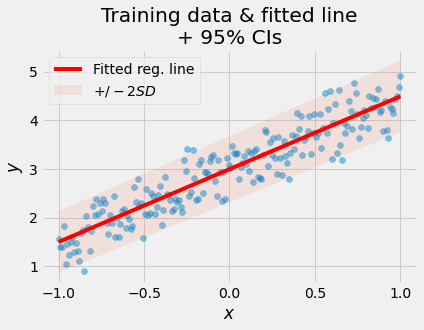

In [32]:
# Compute conf ints
y_sample = model(x_train).sample()
y_hat = model(x_train).mean()
y_sd = model(x_train).stddev()
y_hat_lower = y_hat - 2 * y_sd
y_hat_upper = y_hat + 2 * y_sd

# Plot conf ints
plt.figure(figsize=(6, 4))
plt.scatter(x_train, y_train, alpha=.5)
plt.plot(x_train, y_hat, label='Fitted reg. line', c='r')
plt.fill_between(np.squeeze(x_train), np.squeeze(y_hat_lower), np.squeeze(y_hat_upper), alpha=.1, label='$+/- 2SD$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Training data & fitted line\n+ 95% CIs')
plt.legend()
plt.show()

### * Exercise 2.1 - build a model to estimate aleatoric uncertainty in a non-linear case

In [33]:
# Create non-linear data
n_samples = int(5e3)
x_train = np.linspace(-1, 1, n_samples)[:, np.newaxis]
y_train = x_train**3 + 0.1*(1.5 + x_train)*np.random.randn(n_samples)[:, np.newaxis]

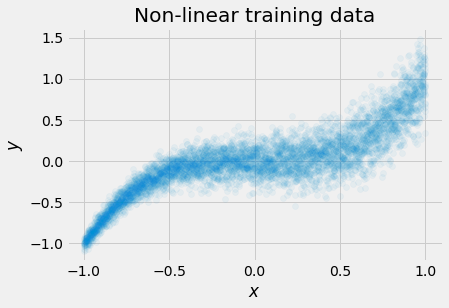

In [34]:
# Plot the data
plt.figure(figsize=(6, 4))
plt.scatter(x_train, y_train, alpha=0.05)
plt.title('Non-linear training data')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [35]:
# Let's build a model with probabilistic output (mean & std) - a simpler way
event_shape = 1

model = tf.keras.Sequential([
    # Add a regular tf layer with non-linearity
    tf.keras.layers.Dense(8, input_shape=(1,), activation='relu'), # YOUR CODE HERE
    # Add a layer to parametrize the output distribution
    tf.keras.layers.Dense(units=tfpl.IndependentNormal.params_size(event_shape)), # YOUR CODE HERE
    # Add the output layer (use `tfd.IndependentNormal` with `event_shape=event_shape`)
    tfpl.IndependentNormal(event_shape) # YOUR CODE HERE
])

# Define neg. loglik. loss function
def neg_loglik(y_true, y_pred):
    return -y_pred.log_prob(y_true)

# Compile 
model.compile(loss=neg_loglik, optimizer='sgd')

# Fit
history = model.fit(x_train, y_train, epochs=500, verbose=0)

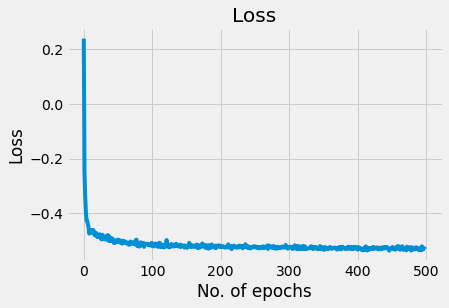

In [36]:
# Plot loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.title('Loss')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.show()

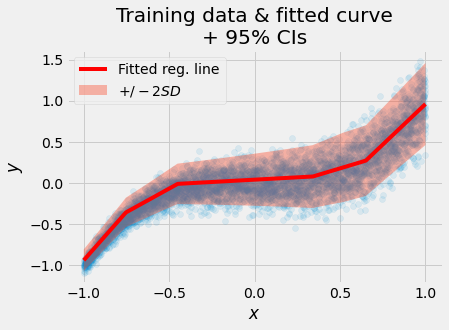

In [37]:
# Compute conf ints
y_sample = model(x_train).sample()
y_hat = model(x_train).mean()
y_sd = model(x_train).stddev()
y_hat_lower = y_hat - 2 * y_sd
y_hat_upper = y_hat + 2 * y_sd

# Plot conf ints
plt.figure(figsize=(6, 4))
plt.scatter(x_train, y_train, alpha=.1)
plt.plot(x_train, y_hat, label='Fitted reg. line', c='r')
plt.fill_between(np.squeeze(x_train), np.squeeze(y_hat_lower), np.squeeze(y_hat_upper), alpha=.4, label='$+/- 2SD$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Training data & fitted curve\n+ 95% CIs')
plt.legend()
plt.show()

## 3. Modeling epistemic uncertainty - `tfpl.DenseVariational`

Now, we're going to model weight's uncertainty. 

This means, that each weight in our network will now be represented by a **distribution**, and **not** just a **point estimate**.

<br><br>

<img src="https://sanjaykthakur.files.wordpress.com/2018/12/bayes_nn.png">
<p style="text-align: center"><sup>Image from <a href="https://sanjaykthakur.com/2018/12/05/the-very-basics-of-bayesian-neural-networks/">https://sanjaykthakur.com/2018/12/05/the-very-basics-of-bayesian-neural-networks/</a></sup></p>

<br><br>

To do this we'll use **Bayes by Backprop** method introduced in a Blundell et al. paper [Weight uncertainty in neural networks](https://arxiv.org/pdf/1505.05424.pdf) (2015).

<br>

We'll try to estimate weight distribution parameters $\theta$, given data $D$:


$$\large P(\theta | D) = \frac{P(D | \theta) P(\theta)}{P(D)} $$


We'll follow a three-step formula to achieve this:

1. Pick a prior density over weights $P(\theta)$
2. Use training data $D$ to determine the likelihood $P(D | \theta)$
3. Estimate the posterior density over weights $P(\theta | D)$ 

<br>

Keywords: [***KL divergence***](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence), [***ELBO***](https://en.wikipedia.org/wiki/Evidence_lower_bound), [***reparametrization trick***](https://gregorygundersen.com/blog/2018/04/29/reparameterization/)

### 3.1 Epistemic uncertainty - linear case

In [38]:
# Let's start with our linear data!
x_train_100 = np.linspace(-1, 1, 100)[:, np.newaxis]
x_train_1000 = np.linspace(-1, 1, 1000)[:, np.newaxis]

y_train_100 = 1.5*x_train_100 + 3 + 0.35*np.random.randn(100)[:, np.newaxis]
y_train_1000 = 1.5*x_train_1000 + 3 + 0.35*np.random.randn(1000)[:, np.newaxis]

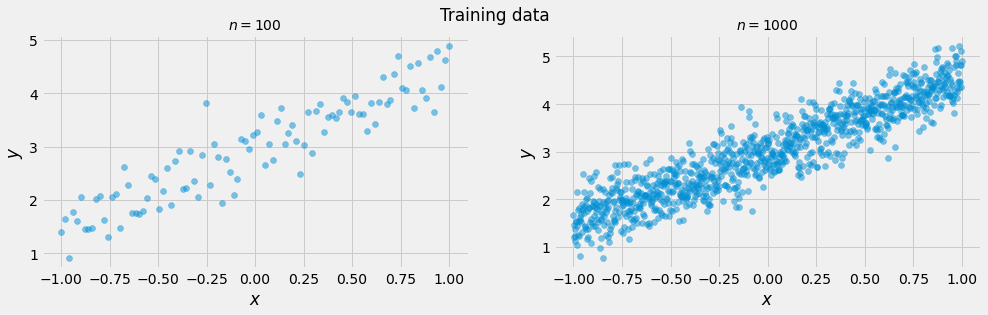

In [39]:
# Plot the data
plt.figure(figsize=(15, 4))

plt.subplot(121)
plt.scatter(x_train_100, y_train_100, alpha=.5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('$n=100$', fontsize=14)

plt.subplot(122)
plt.scatter(x_train_1000, y_train_1000, alpha=.5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('$n=1000$', fontsize=14)

plt.suptitle('Training data')
plt.show()

#### 3.1.1 Define prior and posterior

`prior()` and `posterior()` functions are necessary to parametrize `tfpl.DenseVariational` layer.

They both need to take `kernel_size`, `bias_size` and `dtype` arguments.

In [40]:
# Prior - diagonal MVN ~ N(0, 1)
def prior(kernel_size, bias_size, dtype=None):
    
    n = kernel_size + bias_size
    
    prior_model = tf.keras.Sequential([
       
        tfpl.DistributionLambda(
            # Non-trianable distribution
            lambda t: tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n)))
    ])
    
    return prior_model


# Posterior
def posterior(kernel_size, bias_size, dtype=None):
    
    n = kernel_size + bias_size
    
    posterior_model = tf.keras.Sequential([
        
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    
    return posterior_model

#### 3.1.2 Aleatoric uncertainty - define a model with `DenseVariational` layer

In [41]:
# Define the model
def get_epistemic_model(x_train_shape):
    
    model = tf.keras.Sequential([
        tfpl.DenseVariational(
            1,
            input_shape=(1,),
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1/x_train_shape, # Normalizing to scale the D_KL term in ELBO properly when using minibatches.
            kl_use_exact=False) # could be `True` in this case, but we go for estimated value
    ])

    # Compile
    model.compile(loss='mse', optimizer='sgd')
    
    return model

# Summarize
model = get_epistemic_model(100)
model.summary()

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational (DenseVari (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


### * Exercise 3.1 - understanding the number of parameters

In the summary above we see that we got 5 trainable parameters.

Our model is just a simple linear regression. What are those 5 parameters?

In [42]:
# Fit the model on two datasets 
print('Fitting `model_100`...')
model_100 = get_epistemic_model(100)
history_100 = model_100.fit(x_train_100, y_train_100, epochs=500, verbose=False)

print('Fitting `model_1000`...')
model_1000 = get_epistemic_model(1000)
history_1000 = model_1000.fit(x_train_1000, y_train_1000, epochs=500, verbose=False)

print('Done.')

Fitting `model_100`...
Fitting `model_1000`...
Done.


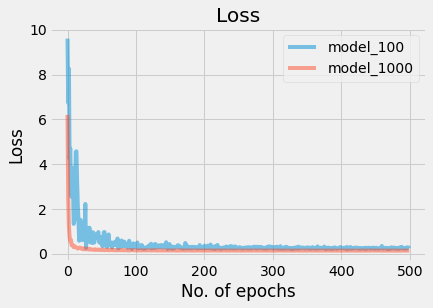

In [43]:
# Plot loss
plt.figure(figsize=(6, 4))
plt.plot(history_100.history['loss'], label='model_100', alpha=.5)
plt.plot(history_1000.history['loss'], label='model_1000', alpha=.5)
plt.title('Loss')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

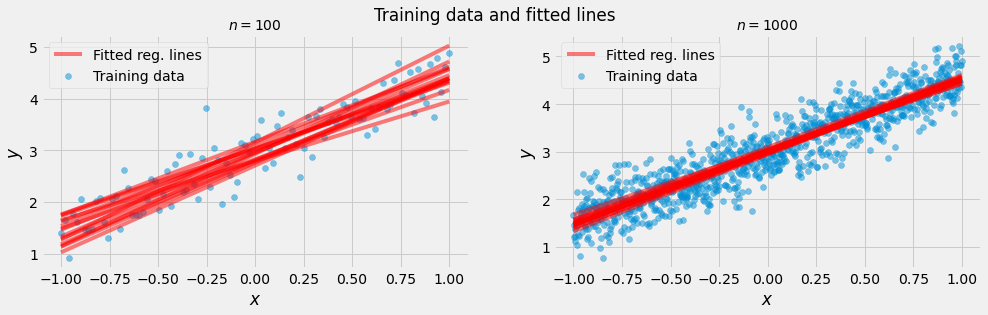

In [44]:
# Plot fitted regression lines
N_ITERS = 15

plt.figure(figsize=(15, 4))

#------------------------------

plt.subplot(121)
plt.scatter(x_train_100, y_train_100, alpha=.5, label='Training data')
for _ in range(N_ITERS):
    y_model_100 = model_100(x_train_100)
    if _ == 0:
        plt.plot(x_train_100, y_model_100, color='red', alpha=0.5, label='Fitted reg. lines')
    else:
        plt.plot(x_train_100, y_model_100, color='red', alpha=0.5)        

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('$n=100$', fontsize=14)
plt.legend()

#------------------------------

plt.subplot(122)
plt.scatter(x_train_1000, y_train_1000, alpha=.5, label='Training data')
for _ in range(N_ITERS):
    y_model_1000 = model_1000(x_train_1000)
    if _ == 0:
        plt.plot(x_train_1000, y_model_1000, color='red', alpha=0.5, label='Fitted reg. lines')
    else:
        plt.plot(x_train_1000, y_model_1000, color='red', alpha=0.5)        

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('$n=1000$', fontsize=14)
plt.legend()

#------------------------------

plt.suptitle('Training data and fitted lines')
plt.show()

## 4. Going fully probabilistic: aleatoric & epistemic uncertainty

### 4.1 Fully probabilistic non-linear case 

In [45]:
# Create non-linear data
n_samples = int(5e3)
x_train = np.linspace(-1, 1, n_samples)[:, np.newaxis]
y_train = x_train**3 + 0.1*(1.5 + x_train)*np.random.randn(n_samples)[:, np.newaxis]

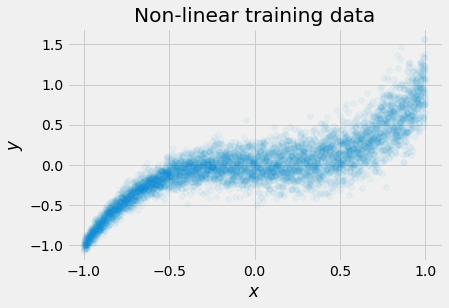

In [46]:
# Plot the data
plt.figure(figsize=(6, 4))
plt.scatter(x_train, y_train, alpha=0.05)
plt.title('Non-linear training data')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [47]:
# Prior - diagonal MVN ~ N(0, 1)
def prior(kernel_size, bias_size, dtype=None):
    
    n = kernel_size + bias_size
    
    prior_model = tf.keras.Sequential([
        
        tfpl.DistributionLambda(
            # Non-trianable distribution
            lambda t: tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n)))
    ])
    
    return prior_model


# Posterior
def posterior(kernel_size, bias_size, dtype=None):
    
    n = kernel_size + bias_size
    
    posterior_model = tf.keras.Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    
    return posterior_model

In [49]:
# Define the model
def get_full_model(x_train_shape):
    
    model = tf.keras.Sequential([

        # Epistemic uncertainty
        tfpl.DenseVariational(units=8,
                              input_shape=(1,),
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_weight=1/x_train_shape,
                              kl_use_exact=False,
                              activation='sigmoid'),
        
        tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_use_exact=False,
                              kl_weight=1/x_train_shape),

        # Aleatoric uncertainty
        tfpl.IndependentNormal(1)
    ])

    def neg_loglik(y_true, y_pred):
        return -y_pred.log_prob(y_true)

    model.compile(loss=neg_loglik, optimizer='rmsprop')
    
    return model

In [50]:
# Get the model
model_full = get_full_model(n_samples)

In [51]:
%%time
# Initialize the model
model_full = get_full_model(n_samples)

# Fit
history = model_full.fit(x_train, y_train, epochs=1000, verbose=0)

Wall time: 3min 14s


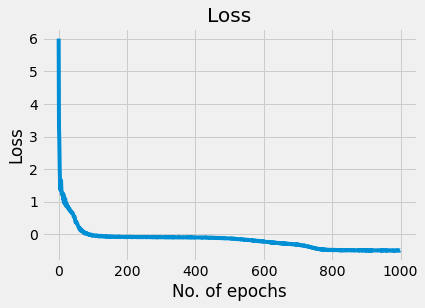

In [52]:
# Plot loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.title('Loss')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.show()

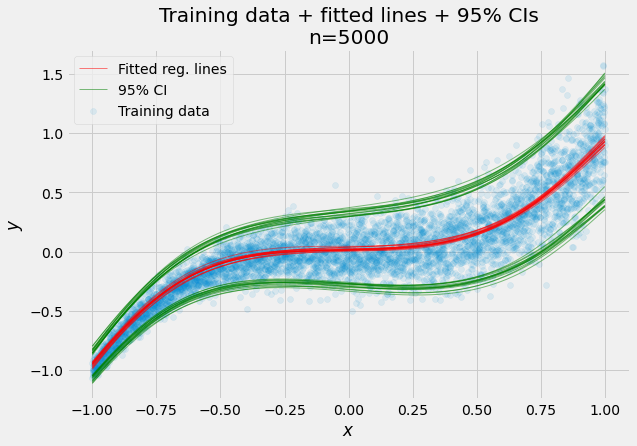

In [53]:
# Plot fitted regression lines
N_ITERS = 15

plt.figure(figsize=(9, 6))

#------------------------------

plt.scatter(x_train, y_train, alpha=.1, label='Training data')
for _ in range(N_ITERS):
    
    # Compute conf ints
    y_sample = model_full(x_train).sample()
    y_hat = model_full(x_train).mean()
    y_sd = model_full(x_train).stddev()
    y_hat_lower = y_hat - 2 * y_sd
    y_hat_upper = y_hat + 2 * y_sd
    

    if _ == 0:
        plt.plot(x_train, y_hat, color='red', alpha=.5, lw=1, label='Fitted reg. lines')
        plt.plot(x_train, y_hat_lower, c='g', alpha=.5, lw=1, label='95% CI')
        plt.plot(x_train, y_hat_upper, c='g', alpha=.5, lw=1)
    else:
        plt.plot(x_train, y_hat, color='red', alpha=.5, lw=1)    
        plt.plot(x_train, y_hat_lower, c='g', alpha=.5, lw=1)
        plt.plot(x_train, y_hat_upper, c='g', alpha=.5, lw=1)

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()

#------------------------------

plt.title(f'Training data + fitted lines + 95% CIs\nn={n_samples}')
plt.show()

## 5. Survey


<br> 

💖 Thank you for **your participation**!

Please let me know what are **your thoughts** on the workshop [**here**](https://forms.gle/uyiC3SogtFzYNim26)